In [1]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import table
from start_plot import *
%matplotlib inline

from astLib import astCoords
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

gband = 'WAVG_MAG_PSF_G_DERED'
rband = 'WAVG_MAG_PSF_R_DERED'
iband = 'WAVG_MAG_PSF_I_DERED'

stream_name = 'Phoenix'

import yaml
stream_lst = yaml.load(open('../Streams/streams_v6.0.yaml'))
dm = stream_lst[stream_name]['modulus']


stream_data = table.Table(pyfits.open('./stream_data/'+stream_name+'.fits')[1].data)

stream_pointing = np.genfromtxt('./stream_pointing_maps_v2.csv', delimiter=',', dtype=None, names=True)
stream_pointing = stream_pointing[stream_pointing['stream'] == stream_name]


/Users/tingli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [2]:

# making actual selections/cuts -- CMD cut and color-color cut
dotter = np.loadtxt('/Users/tingli/.ugali/isochrones/dotter/iso_a12.5_z0.00010.dat')
dotter_g = dotter[:, 6]
dotter_r = dotter[:, 7]

dm_m92_harris = 14.59
m92ebv = 0.023
m92ag = m92ebv * 3.184
m92ar = m92ebv * 2.130
m92_hb_r = np.array([16.8, 15.8, 15.38, 15.1])
m92_hb_col = np.array([-0.36, -0.3, -0.2, -0.0])
m92_hb_g = m92_hb_r + m92_hb_col
des_m92_hb_g = m92_hb_g - 0.104 * (m92_hb_g - m92_hb_r) + 0.01
des_m92_hb_r = m92_hb_r - 0.102 * (m92_hb_g - m92_hb_r) + 0.02
des_m92_hb_g = des_m92_hb_g - m92ag
des_m92_hb_r = des_m92_hb_r - m92ar

# CMD cut for RGB
grw = 0.05 # RGB width in gr
gw = 0.4 # RGB width in g
rmin = 15
rmax = 19.3
grmin = 0.
grmax = 1.1
magrange = (stream_data[rband] > rmin) & (stream_data[rband] < rmax) & (stream_data[gband] - stream_data[rband] < grmax) & (
stream_data[gband] - stream_data[rband] > grmin)
gr = np.interp(stream_data[gband], dotter_g[::-1] + dm, dotter_g[::-1] - dotter_r[::-1], left=np.nan, right=np.nan)
gg = np.interp(stream_data[gband] - stream_data[rband], dotter_g[dotter_g < 4] - dotter_r[dotter_g < 4],
               dotter_g[dotter_g < 4] + dm, left=np.nan, right=np.nan)
del_color_cmd = stream_data[gband] - stream_data[rband] - gr
del_g_cmd = stream_data[gband] - gg

# CMD cut for BHB
grw_bhb = 0.10 # BHB width in gr
gw_bhb = 0.4  # BHB width in g
grmin_bhb = -0.5
grmax_bhb = 0
magrange_bhb = (stream_data[rband] > rmin) & (stream_data[rband] < rmax) & (stream_data[gband] - stream_data[rband] < grmax_bhb) & (
stream_data[gband] - stream_data[rband] > grmin_bhb)
gr_bhb = np.interp(stream_data[gband], des_m92_hb_g + dm - dm_m92_harris, des_m92_hb_g - des_m92_hb_r, left=np.nan,
                   right=np.nan)
gg_bhb = np.interp(stream_data[gband] - stream_data[rband], des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris,
                   left=np.nan, right=np.nan)
del_color_cmd_bhb = stream_data[gband] - stream_data[rband] - gr_bhb
del_g_cmd_bhb = stream_data[gband] - gg_bhb

stream_data['del_color_cmd'] = del_color_cmd
stream_data['del_g_cmd'] = del_g_cmd
stream_data['del_color_cmd_bhb'] = del_color_cmd_bhb
stream_data['del_g_cmd_bhb'] = del_g_cmd_bhb

colorrange = magrange & ((abs(del_color_cmd) < grw) | (abs(del_g_cmd) < gw))
colorrange_bhb = magrange_bhb & ((abs(del_color_cmd_bhb) < grw_bhb) | (abs(del_g_cmd_bhb) < gw_bhb))
colorrange = colorrange | colorrange_bhb

# Add CMD cut as cmd column
stream_data['cmd'] = np.zeros_like(stream_data['COADD_OBJECT_ID'])
stream_data['cmd'][colorrange] = 1

# Color-color cut here to selection metal-poor stars
sl = pyfits.open('/Users/tingli/Dropbox/dwarfgalaxy/AAT/TucIII/y3a2_empirical_stellar_locus_griz.fits')[1].data
ri = np.interp(stream_data[gband] - stream_data[rband], sl['g'] - sl['r'], sl['r'] - sl['i'])
del_ri_locus = stream_data[rband] - stream_data[iband] - ri
stream_data['del_ri_locus'] = del_ri_locus

# cuts used for color-color selection on RGB stars
rilow = 0.02 # metal-poor stars cut for RGB. v1 = 0.02, v2 = 0.01
rihigh = 0.06 # metal-poor stars cut for RGB
fehrange = ( del_ri_locus > rilow) & (del_ri_locus < rihigh)
# color-color cut on BHB is just a big box
fehrange_bhb = (stream_data[gband] - stream_data[rband] < 0) & (stream_data[gband] - stream_data[rband] > -0.5) & (
stream_data[rband] - stream_data[iband] < 0) & (stream_data[rband] - stream_data[iband] > -0.5)

# Add color-color cut
fehrange = fehrange | fehrange_bhb
stream_data['mp'] = np.zeros_like(stream_data['COADD_OBJECT_ID'])
stream_data['mp'][fehrange] = 1

# Calculate ri distance to the dotter isochrone.
dotter1 = np.loadtxt('/Users/tingli/.ugali/isochrones/dotter/iso_a12.5_z0.00010.dat')
dotter1_g = dotter1[:, 6]
dotter1_r = dotter1[:, 7]
dotter1_i = dotter1[:, 8]
logg = dotter1[:, 3]
giant = logg < 4
ridotter = np.interp(stream_data[gband] - stream_data[rband], dotter1_g[giant] - dotter1_r[giant],
                     dotter1_r[giant] - dotter1_i[giant])
delri = (stream_data[rband] - stream_data[iband]) - ridotter
stream_data['del_ri_dotter'] = delri
stream_data['ri_err'] = np.sqrt(stream_data['WAVG_MAGERR_PSF_R'] ** 2 + stream_data['WAVG_MAGERR_PSF_I'] ** 2 + 0.008 ** 2)


pw = 0.5
posrange = (stream_data['PHI2'] < pw) & (stream_data['PHI2'] > -pw) 
posback1 = (stream_data['PHI2'] < pw + 1.5) & (stream_data['PHI2'] > -pw + 1.5)
posback2 = (stream_data['PHI2'] < pw - 1.5) & (stream_data['PHI2'] > -pw - 1.5)

sum(posrange)

/Users/tingli/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


46901

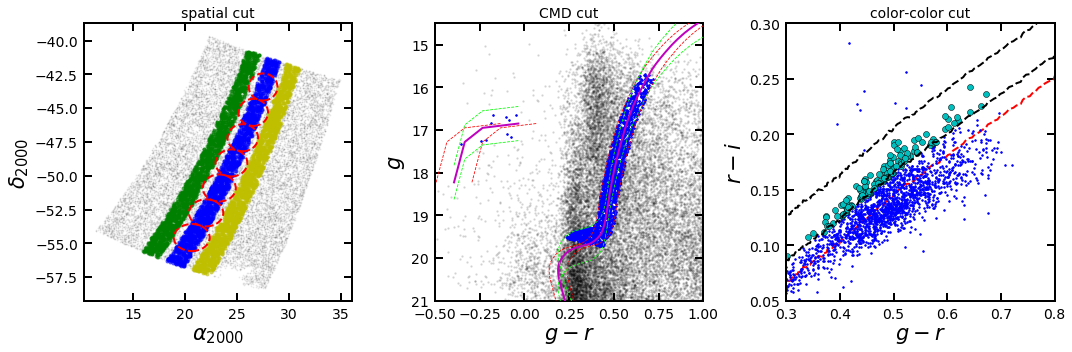

In [3]:
#plt.plot(stream_data['RA'], stream_data['DEC'],'.', alpha=0.01)
plt.figure(figsize=[15,5])

f1s1 = plt.subplot(131)
plt.plot(stream_data[colorrange]['RA'], stream_data[colorrange]['DEC'],'.k',ms=2,alpha=0.05)
plt.plot(stream_data[colorrange&posrange]['RA'], stream_data[colorrange&posrange]['DEC'],'b.', alpha=0.5)
plt.plot(stream_data[colorrange&posback1]['RA'], stream_data[colorrange&posback1]['DEC'],'g.', alpha=0.5)
plt.plot(stream_data[colorrange&posback2]['RA'], stream_data[colorrange&posback2]['DEC'],'y.', alpha=0.5)

from matplotlib.patches import Ellipse
for i in range(len(stream_pointing)):
    ells = Ellipse(xy=(stream_pointing['ra'][i], stream_pointing['dec'][i]), width=2/np.cos(stream_pointing['dec'][i]/180.*np.pi), height=2 , angle=0 , fc=None, ec='red', lw=2,fill=False, ls='--', zorder = 60) 
    f1s1.add_artist(ells)


#plt.xlim(30.5, 9.5)
#plt.ylim(-35,-19.8)

plt.xlabel('$\\alpha_{2000}$')
plt.ylabel('$\\delta_{2000}$')
plt.title('spatial cut')


plt.subplot(132)
plt.plot(stream_data[gband][posrange]-stream_data[rband][posrange],stream_data[gband][posrange],'k.',ms = 3, alpha=0.1 )
plt.plot(stream_data[gband][colorrange&posrange]-stream_data[rband][colorrange&posrange],stream_data[gband][colorrange&posrange],'.b',ms = 3, alpha=1 )

plt.plot(dotter_g - dotter_r, dotter_g + dm, color='m', lw=2, zorder=16)
plt.plot(dotter_g - dotter_r - grw, dotter_g + dm, '--', color='r', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r + grw, dotter_g + dm, '--', color='r', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r, dotter_g + dm - gw, '--', color='lime', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r, dotter_g + dm + gw, '--', color='lime', lw=0.8, zorder=16)

plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris, color='m', lw=2, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r - grw_bhb, des_m92_hb_g + dm - dm_m92_harris, '--', color='r', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r + grw_bhb, des_m92_hb_g + dm - dm_m92_harris, '--', color='r', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris - gw_bhb, '--', color='lime', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris + gw_bhb, '--', color='lime', lw=0.8, zorder=16)


plt.xlim(-0.5,1)
plt.ylim(21.,14.5)

plt.xlabel('$g-r$')
plt.ylabel('$g$')
plt.title('CMD cut')



plt.subplot(133)
plt.plot(sl['g']-sl['r'],sl['r']-sl['i'], 'r--',lw=2)

plt.plot(stream_data[gband][colorrange&posrange]-stream_data[rband][colorrange&posrange],stream_data[rband][colorrange&posrange]-stream_data[iband][colorrange&posrange],'.b',ms=3,alpha=1)

plt.plot(stream_data[gband][colorrange&posrange&fehrange]-stream_data[rband][colorrange&posrange&fehrange],stream_data[rband][colorrange&posrange&fehrange]-stream_data[iband][colorrange&posrange&fehrange],'o',color='c',mew=0.5, mec='k',alpha=1)
plt.plot(sl['g']-sl['r'],sl['r']-sl['i']+rilow, 'k--',lw=2)
plt.plot(sl['g']-sl['r'],sl['r']-sl['i']+rihigh, 'k--',lw=2)


plt.xlim(0.3,0.8)
plt.ylim(0.05,0.3)
plt.xlabel('$g-r$')
plt.ylabel('$r-i$')
plt.title('color-color cut')

#bd = np.interp(stream_data[gband]-stream_data[rband],sl['g']-sl['r'],sl['r']-sl['i'])
#mp = stream_data[rband]-stream_data[iband] > bd

#plt.plot(stream_data[gband][mp]-stream_data[rband][mp],stream_data[rband][mp]-stream_data[iband][mp],'.',alpha=0.05)




plt.tight_layout()


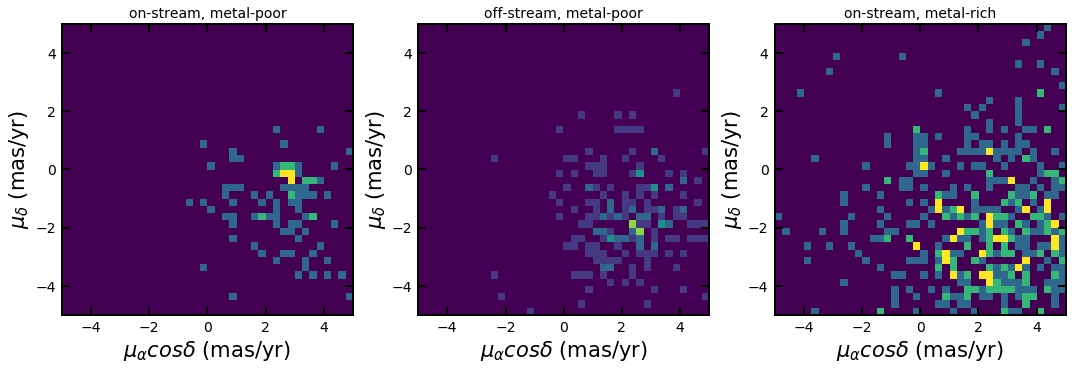

In [4]:
xmin,xmax,ymin,ymax = -5, 5, -5, 5
vmax=3

hist21, binx, biny = np.histogram2d(stream_data[colorrange&posrange&fehrange]['PMRA0'], stream_data[colorrange&posrange&fehrange]['PMDEC0'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )
hist22, binx, biny = np.histogram2d(stream_data[colorrange&posback1&fehrange]['PMRA0'], stream_data[colorrange&posback1&fehrange]['PMDEC0'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )
hist23, binx, biny = np.histogram2d(stream_data[colorrange&posback2&fehrange]['PMRA0'], stream_data[colorrange&posback2&fehrange]['PMDEC0'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )
hist24, binx, biny = np.histogram2d(stream_data[colorrange&posrange&~fehrange]['PMRA0'], stream_data[colorrange&posrange&~fehrange]['PMDEC0'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )

plt.figure(figsize=[15,5])
plt.subplot(131)

S = hist21
plt.imshow(S.T, interpolation='nearest', extent=[xmin, xmax, ymax, ymin], vmin = 0, vmax = vmax)


plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_\\alpha cos\\delta$ (mas/yr)')
plt.ylabel('$\mu_\\delta$ (mas/yr)')
plt.title('on-stream, metal-poor')

plt.subplot(132)
B = 0.5*(hist22+hist23)
plt.imshow(B.T, interpolation='nearest', extent=[xmin, xmax, ymax, ymin], vmin = 0, vmax = vmax)
plt.title('off-stream, metal-poor')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_\\alpha cos\\delta$ (mas/yr)')
plt.ylabel('$\mu_\\delta$ (mas/yr)')
plt.subplot(133)


#plt.hist2d(stream_data[colorrange&posback2&fehrange]['PMRA0'], stream_data[colorrange&posback2&fehrange]['PMDEC0'], bins=50, range=[[xmin,xmax],[ymin,ymax]], vmin=0, vmax=vmax )

plt.imshow(hist24.T, interpolation='nearest', extent=[xmin, xmax, ymax, ymin], vmin = 0, vmax = vmax)
#plt.plot(atlas_mem['PMRA0'], atlas_mem['PMDEC0'],'*', mfc='w', mec='r', mew=1, ms=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_\\alpha cos\\delta$ (mas/yr)')
plt.ylabel('$\mu_\\delta$ (mas/yr)')
plt.title('on-stream, metal-rich')

plt.tight_layout()
#plt.colorbar()


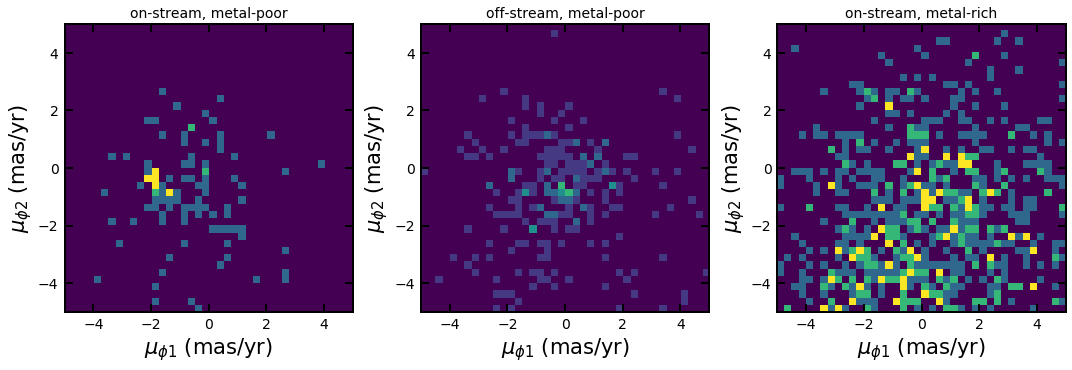

In [5]:
xmin,xmax,ymin,ymax = -5, 5, -5, 5
vmax=3

hist21, binx, biny = np.histogram2d(stream_data[colorrange&posrange&fehrange]['PMPHI1'], stream_data[colorrange&posrange&fehrange]['PMPHI2'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )
hist22, binx, biny = np.histogram2d(stream_data[colorrange&posback1&fehrange]['PMPHI1'], stream_data[colorrange&posback1&fehrange]['PMPHI2'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )
hist23, binx, biny = np.histogram2d(stream_data[colorrange&posback2&fehrange]['PMPHI1'], stream_data[colorrange&posback2&fehrange]['PMPHI2'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )
hist24, binx, biny = np.histogram2d(stream_data[colorrange&posrange&~fehrange]['PMPHI1'], stream_data[colorrange&posrange&~fehrange]['PMPHI2'], bins=40, range=[[xmin,xmax],[ymin,ymax]] )

plt.figure(figsize=[15,5])
plt.subplot(131)

S = hist21
plt.imshow(S.T, interpolation='nearest', extent=[xmin, xmax, ymax, ymin], vmin = 0, vmax = vmax)


plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_{\\phi1}$ (mas/yr)')
plt.ylabel('$\mu_{\\phi2}$ (mas/yr)')
plt.title('on-stream, metal-poor')

plt.subplot(132)
B = 0.5*(hist22+hist23)
plt.imshow(B.T, interpolation='nearest', extent=[xmin, xmax, ymax, ymin], vmin = 0, vmax = vmax)
plt.title('off-stream, metal-poor')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_{\\phi1}$ (mas/yr)')
plt.ylabel('$\mu_{\\phi2}$ (mas/yr)')
plt.subplot(133)


#plt.hist2d(stream_data[colorrange&posback2&fehrange]['PMRA0'], stream_data[colorrange&posback2&fehrange]['pmdec'], bins=50, range=[[xmin,xmax],[ymin,ymax]], vmin=0, vmax=vmax )

plt.imshow(hist24.T, interpolation='nearest', extent=[xmin, xmax, ymax, ymin], vmin = 0, vmax = vmax)
#plt.plot(atlas_mem['PMRA0'], atlas_mem['pmdec'],'*', mfc='w', mec='r', mew=1, ms=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_{\\phi1}$ (mas/yr)')
plt.ylabel('$\mu_{\\phi2}$ (mas/yr)')
plt.title('on-stream, metal-rich')

plt.tight_layout()
#plt.colorbar()


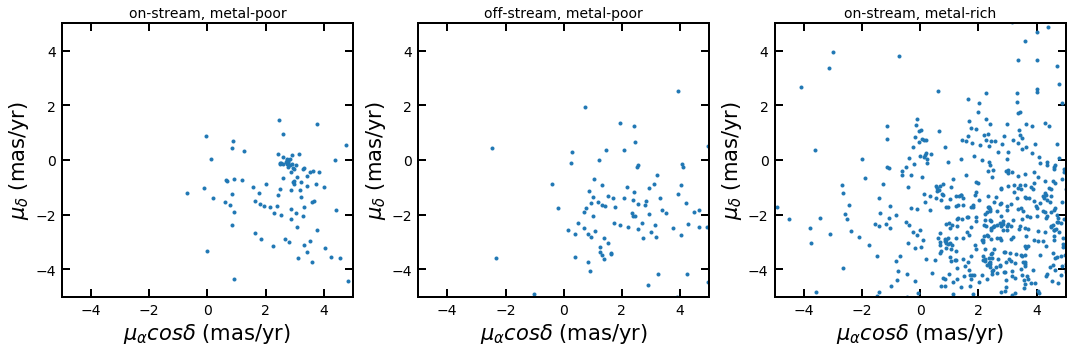

In [6]:
xmin,xmax,ymin,ymax = -5, 5, -5, 5


plt.figure(figsize=[15,5])
plt.subplot(131)

plt.plot(stream_data[colorrange&posrange&fehrange]['PMRA0'], stream_data[colorrange&posrange&fehrange]['PMDEC0'], '.')


plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_\\alpha cos\\delta$ (mas/yr)')
plt.ylabel('$\mu_\\delta$ (mas/yr)')
plt.title('on-stream, metal-poor')

plt.subplot(132)
plt.plot(stream_data[colorrange&posback1&fehrange]['PMRA0'], stream_data[colorrange&posback1&fehrange]['PMDEC0'], '.')
#plt.plot(atlas_mem['PMRA0'], atlas_mem['pmdec'],'*', mfc='w', mec='r', mew=1, ms=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_\\alpha cos\\delta$ (mas/yr)')
plt.ylabel('$\mu_\\delta$ (mas/yr)')
plt.title('off-stream, metal-poor')


plt.subplot(133)

plt.plot(stream_data[colorrange&posrange&~fehrange]['PMRA0'], stream_data[colorrange&posrange&~fehrange]['PMDEC0'],'.')
#plt.plot(atlas_mem['PMRA0'], atlas_mem['pmdec'],'*', mfc='w', mec='r', mew=1, ms=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_\\alpha cos\\delta$ (mas/yr)')
plt.ylabel('$\mu_\\delta$ (mas/yr)')
plt.title('on-stream, metal-rich')

plt.tight_layout()
#plt.colorbar()


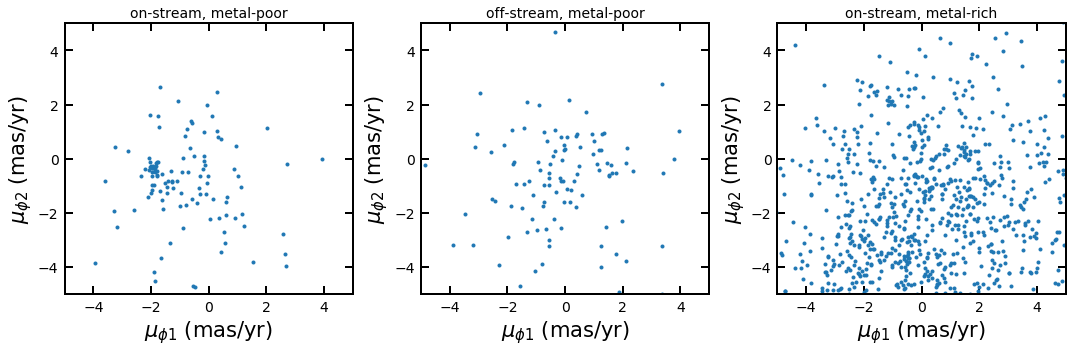

In [7]:
xmin,xmax,ymin,ymax = -5, 5, -5, 5


plt.figure(figsize=[15,5])
plt.subplot(131)

plt.plot(stream_data[colorrange&posrange&fehrange]['PMPHI1'], stream_data[colorrange&posrange&fehrange]['PMPHI2'], '.')


plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_{\\phi1}$ (mas/yr)')
plt.ylabel('$\mu_{\\phi2}$ (mas/yr)')
plt.title('on-stream, metal-poor')

plt.subplot(132)
plt.plot(stream_data[colorrange&posback1&fehrange]['PMPHI1'], stream_data[colorrange&posback1&fehrange]['PMPHI2'], '.')
#plt.plot(atlas_mem['PMRA0'], atlas_mem['pmdec'],'*', mfc='w', mec='r', mew=1, ms=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_{\\phi1}$ (mas/yr)')
plt.ylabel('$\mu_{\\phi2}$ (mas/yr)')
plt.title('off-stream, metal-poor')


plt.subplot(133)

plt.plot(stream_data[colorrange&posrange&~fehrange]['PMPHI1'], stream_data[colorrange&posrange&~fehrange]['PMPHI2'],'.')
#plt.plot(atlas_mem['PMRA0'], atlas_mem['pmdec'],'*', mfc='w', mec='r', mew=1, ms=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xlabel('$\mu_{\\phi1}$ (mas/yr)')
plt.ylabel('$\mu_{\\phi2}$ (mas/yr)')
plt.title('on-stream, metal-rich')

plt.tight_layout()
#plt.colorbar()
